Social media sentiment analysis

Load data

In [1]:
import sqlite3
import pandas as pd

con = sqlite3.connect('co_reddit.sqlite')
df = pd.read_sql_query('SELECT * from posts;', con)
con.close()
df

,title,link,author,n_comments,score,text
0,the good times,/r/poland/comments/1b71beh/the_good_times/,VeryRegularName,181,2268,
1,"That's how voice-over (""lektor"") in films in P...",/r/poland/comments/1b7gmv3/thats_how_voiceover...,Kamil1707,19,115,
2,Od niepamiętnych czasów Rosja uwielbiała memy ...,/r/poland/comments/1b75gbq/od_niepamiętnych_cz...,Pika400,24,326,"Nie słuchaj ich, bobrze, nie jesteś kurwa, jes..."
3,Ethnographic map of Poland in 1919,/r/poland/comments/1b75mj2/ethnographic_map_of...,KotwPaski,16,80,
4,NATO conducts major 'Steadfast Defender' exerc...,/r/poland/comments/1b7ewdi/nato_conducts_major...,EdmontonBest,1,1,
...,...,...,...,...,...,...
204,Returning from work at Żabka,/r/poland/comments/1an2i2m/returning_from_work...,Negative-Fruit-6094,5,125,"I, returning from work at 1 AM from work at Ża..."
205,What did you think of the Tucker Carlson and P...,/r/poland/comments/1amkvhm/what_did_you_think_...,SnipedtheSniper,481,566,
206,"For Poles living in the US or UK, do you hang ...",/r/poland/comments/1amtdjk/for_poles_living_in...,Fine-Upstairs-6284,83,39,Curious to see what others say about this. I g...
207,Potwierdzenie profilu zaufany,/r/poland/comments/1an1qyi/potwierdzenie_profi...,Admirable-Union-9041,4,4,Is there a way to renew this profile online or...


Since most of our text is missing for this subreddit, we'll just use the title of the posts. However, if you have text from each post or comments for each post, you could combine those with the title.

Keyword sentiment 

We will start with a keyword sentiment analysis technique. Let's first load a dictionary of words and sentiment values:

In [2]:
sentiment_df = pd.read_csv('AFINN-en-165.txt', sep='\t', names=['word', 'score'],index_col ='word')

In [3]:
sentiment_df

,score
word,
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
...,...
yucky,-2
yummy,3
zealot,-2


In [4]:
sentiment_dict = sentiment_df.to_dict()['score']

Here, we load the data into a dataframe. There is no header so we provide the column names with the `names` argument. Then we set the word as the index, which helps with the next step where we convert the dataframe to a dictionary. This has the column names as keys, then the values are dictionaries with the index value as keys and the column values as values. So we get a dictionary like this:

```python
{'abandon': -2,
 'abandoned': -2,
 'abandons': -2,
 'abducted': -2,
 ...
}
```

Now we can get the average sentiment for each string we have in our original dataframe, which is the title of each post. We get the scores for each word and take the average for each title:

In [5]:
import numpy as np

title_sentiments = []
for title in df['title']:
    words = title.lower().split()
    this_titles_sentiments = []
    for w in words:
        if w in sentiment_dict.keys():
            this_titles_sentiments.append(sentiment_dict[w])
        else:
            this_titles_sentiments.append(0)
            
    
    title_sentiments.append(np.mean(this_titles_sentiments))

In [6]:
df['keyword_sentiment'] = title_sentiments

<Axes: ylabel='Frequency'>

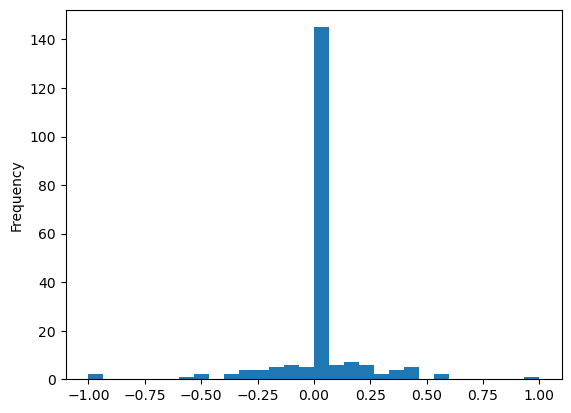

In [7]:
df['keyword_sentiment'].plot.hist(bins=30)

In [8]:
df['keyword_sentiment'].mean()

0.006118817051783505

In [9]:
df['keyword_sentiment'].median()

0.0

create a new column in our original dataframe with sentiments 

Let's look at some of the top and bottom sentiment posts

In [20]:
df.sort_values(by='keyword_sentiment')[['title', 'keyword_sentiment']]

,title,keyword_sentiment
98,„apolitical” protest,-1.000000
6,Forever lost biscuits,-1.000000
88,Advice needed for a return fraud claim,-0.571429
58,Municipal grave lease expiring,-0.500000
10,Karolina Maj spam calls,-0.500000
...,...,...
155,Happy belated Valentine's Day from Polish forr...,0.428571
110,Perfect crisps to cheer you up on that solo mo...,0.454545
102,Help with poczta polska please,0.600000
113,Best MMA Gyms in Poland?,0.600000


In [21]:
# full titles of the bottom 10 sentiments
df.sort_values(by='keyword_sentiment')['title'].to_list()[:10]

['„apolitical” protest',
 'Forever lost biscuits',
 'Advice needed for a return fraud claim',
 'Municipal grave lease expiring',
 'Karolina Maj spam calls',
 'Current Job Market - Desperate for some advice!',
 'Stolen credit card data - show I bother reporting to someone?',
 'Putin: "Poland provoked Hitler to start World War II"',
 'Which city embarrasses you the most?',
 'Ukraine warns of “retaliatory measures” if Poland does not end farmers’ border blockade']

In [22]:
# full titles of the top 10 sentiments
df.sort_values(by='keyword_sentiment', ascending=False)['title'].to_list()[:10]

['the good times',
 'Best MMA Gyms in Poland?',
 'Help with poczta polska please',
 'Perfect crisps to cheer you up on that solo movie night',
 'Karta Polaka experience? Would love to hear!',
 'Good companies to buy an office chair?',
 "Happy belated Valentine's Day from Polish forrests!",
 'Need help shipping to Sweden',
 'Is the architecture job market good in Poland?',
 'Selling a vehicle document help needed']

# Using Python packages for sentiment analysis

There are a few Python packages that use rule-based and keyword-based sentiment analysis. We will look at VADER 

In [13]:
conda install -c conda-forge textblob vadersentiment -y

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




In [14]:
from textblob import TextBlob

tb = TextBlob("April snowstorms make for some beautiful pictures...")
tb.sentiment

Sentiment(polarity=0.85, subjectivity=1.0)

Textblob requires us to use their TextBlob class on a string. Then we can get the sentiment score. It gives us polarity (-1 to =1) and subjectivite (0 to 1, objective to subjective). We can see this sentence is rated fully subjective and has a positive sentiment, which makes sense. We can apply it to the whole dataframe like so:

In [15]:
def get_tb_sentiment(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

df['tb_sentiment'] = df['title'].apply(get_tb_sentiment)

Because we need to do a few steps to get the polarity (sentiment) score, we wrote a short function to do it. Then we use the pandas `apply` function to apply this to the whole dataframe.

Note: If you have a lot of data and want to speed this up, look at the `swifter` package for parallelizing the `apply` function.

Now we can look at the distribution of these sentiments:

<Axes: ylabel='Frequency'>

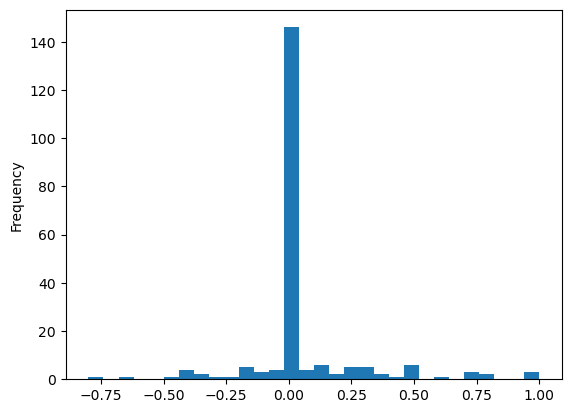

In [16]:
df['tb_sentiment'].plot.hist(bins=30)

In [17]:
df['tb_sentiment'].mean()

0.045186571801404334

We can see the distribution looks similar but is more spread out than our AFINN method. textblob has more words in its lookup dictionary than the AFINN dictionary we used.

VADER is similar to use:

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("April snowstorms make for some beautiful pictures...")

{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.5994}

In [19]:
analyzer.polarity_scores("April snowstorms make for some beautiful pictures...")['compound']

0.5994